# Install PYSPARK

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget https://archive.apache.org/dist/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz
!cp /content/drive/MyDrive/MMDS/spark-3.5.4-bin-hadoop3.tgz .
!tar -xvf spark-3.5.4-bin-hadoop3.tgz
! pip install -q findspark

spark-3.5.4-bin-hadoop3/
spark-3.5.4-bin-hadoop3/R/
spark-3.5.4-bin-hadoop3/R/lib/
spark-3.5.4-bin-hadoop3/R/lib/SparkR/
spark-3.5.4-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.5.4-bin-hadoop3/R/lib/SparkR/R/
spark-3.5.4-bin-hadoop3/R/lib/SparkR/R/SparkR
spark-3.5.4-bin-hadoop3/R/lib/SparkR/R/SparkR.rdb
spark-3.5.4-bin-hadoop3/R/lib/SparkR/R/SparkR.rdx
spark-3.5.4-bin-hadoop3/R/lib/SparkR/NAMESPACE
spark-3.5.4-bin-hadoop3/R/lib/SparkR/profile/
spark-3.5.4-bin-hadoop3/R/lib/SparkR/profile/shell.R
spark-3.5.4-bin-hadoop3/R/lib/SparkR/profile/general.R
spark-3.5.4-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.5.4-bin-hadoop3/R/lib/SparkR/doc/
spark-3.5.4-bin-hadoop3/R/lib/SparkR/doc/sparkr-vignettes.html
spark-3.5.4-bin-hadoop3/R/lib/SparkR/doc/sparkr-vignettes.Rmd
spark-3.5.4-bin-hadoop3/R/lib/SparkR/doc/index.html
spark-3.5.4-bin-hadoop3/R/lib/SparkR/doc/sparkr-vignettes.R
spark-3.5.4-bin-hadoop3/R/lib/SparkR/html/
spark-3.5.4-bin-hadoop3/R/lib/SparkR/html/00Index.html
spark-3.5.4-bin-hadoop3

In [3]:
! du -sh spark-3.5.4-bin-hadoop3.tgz

383M	spark-3.5.4-bin-hadoop3.tgz


In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.4-bin-hadoop3"

In [5]:
! echo $JAVA_HOME

/usr/lib/jvm/java-8-openjdk-amd64


In [6]:
! echo $SPARK_HOME

/content/spark-3.5.4-bin-hadoop3


In [7]:
import findspark
findspark.init()

In [8]:
import pyspark as spark

print(spark.__version__)

3.5.4


#Load the CSV File into a DataFrame:

In [9]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MinHashLSH for Similar Dates") \
    .getOrCreate()

In [10]:
# Path to the CSV file in Google Drive
file_path = "/content/drive/My Drive/MMDS/baskets.csv"

# Load the CSV into a DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the DataFrame to verify
df.show()

+-------------+----------+--------------------+----+-----+---+-----------+
|Member_number|      Date|     itemDescription|year|month|day|day_of_week|
+-------------+----------+--------------------+----+-----+---+-----------+
|         1249|01/01/2014|        citrus fruit|2014|    1|  1|          2|
|         1249|01/01/2014|              coffee|2014|    1|  1|          2|
|         1381|01/01/2014|                curd|2014|    1|  1|          2|
|         1381|01/01/2014|                soda|2014|    1|  1|          2|
|         1440|01/01/2014|    other vegetables|2014|    1|  1|          2|
|         1440|01/01/2014|              yogurt|2014|    1|  1|          2|
|         1659|01/01/2014| specialty chocolate|2014|    1|  1|          2|
|         1659|01/01/2014|   frozen vegetables|2014|    1|  1|          2|
|         1789|01/01/2014|      hamburger meat|2014|    1|  1|          2|
|         1789|01/01/2014|             candles|2014|    1|  1|          2|
|         1922|01/01/2014

#Preprocess the Data

In [11]:
from pyspark.sql.functions import collect_set

# Group by Date and collect distinct items
date_items_df = df.groupBy("Date").agg(collect_set("itemDescription").alias("items"))

# Show the result
date_items_df.show(truncate=False)

+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Date      |items                                                                                                                                                                                                                                                                                                                                                                                                                      

#Approach 1 - MinHashLSH

In [12]:
from pyspark.ml.feature import CountVectorizer

# Use CountVectorizer to convert the items list into a sparse vector
cv = CountVectorizer(inputCol="items", outputCol="features")
cv_model = cv.fit(date_items_df)
vectorized_df = cv_model.transform(date_items_df)

# Show the result
vectorized_df.show(truncate=False)

+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Date      |items                                                                                               

In [13]:
from pyspark.ml.feature import MinHashLSH
from pyspark.sql.functions import col, lit, round
import time

# Function to run MinHashLSH for a given similarity threshold s
def run_minhash_lsh(similarity_threshold):
    start_time = time.time()


    distance_threshold = 1 - similarity_threshold

    # Initialize MinHashLSH
    mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=20)
    mh_model = mh.fit(vectorized_df)

    # Find approximate nearest neighbors with Jaccard similarity > similarity_threshold
    result = mh_model.approxSimilarityJoin(vectorized_df, vectorized_df, distance_threshold, distCol="JaccardDistance") \
        .select(
            col("datasetA.Date").alias("Date1"),
            col("datasetB.Date").alias("Date2"),
            # col("JaccardDistance"),
            round(lit(1) - col("JaccardDistance"), 3).alias("JaccardSimilarity")
        )

    # Filter out self-pairs and ensure Jaccard similarity is strictly greater than threshold
    result = result.filter((col("Date1") < col("Date2")) &
                          (col("JaccardSimilarity") > similarity_threshold))

    # Show the result
    result.show()
    num_pairs = result.count()
    print("Số cặp có Jaccard similarity >", similarity_threshold, ":", num_pairs)
    end_time = time.time()
    print('time',end_time - start_time)
    return end_time - start_time

# Find similarity pair > 0.1
time_minhash_05 = run_minhash_lsh(0.1)

+----------+----------+-----------------+
|     Date1|     Date2|JaccardSimilarity|
+----------+----------+-----------------+
|01/01/2014|01/01/2015|            0.306|
|01/01/2014|01/02/2014|            0.288|
|01/01/2014|01/07/2015|            0.294|
|01/01/2014|01/09/2014|            0.226|
|01/01/2014|01/10/2014|            0.163|
|01/01/2014|01/12/2014|            0.288|
|01/01/2014|01/12/2015|            0.184|
|01/01/2014|02/02/2014|            0.326|
|01/01/2014|02/03/2014|            0.346|
|01/01/2014|02/04/2015|            0.145|
|01/01/2014|02/07/2014|            0.234|
|01/01/2014|02/08/2015|            0.348|
|01/01/2014|02/11/2014|            0.229|
|01/01/2014|02/12/2014|            0.271|
|01/01/2014|02/12/2015|            0.362|
|01/01/2014|03/02/2015|            0.315|
|01/01/2014|03/06/2014|            0.319|
|01/01/2014|03/07/2015|            0.426|
|01/01/2014|03/09/2015|            0.304|
|01/01/2014|03/10/2014|            0.208|
+----------+----------+-----------

#Approach 2 - Manual Implementation

In [14]:
from pyspark.sql.functions import col, broadcast,udf
from pyspark.sql.types import DoubleType
import time

def jaccard_similarity(set1, set2):
    set1, set2 = set(set1), set(set2)
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return float(intersection) / union if union != 0 else 0.0

jaccard_udf = udf(jaccard_similarity, DoubleType())

def run_optimized_manual_jaccard(s):
    start_time = time.time()

    # Nếu một DataFrame nhỏ hơn nhiều, có thể sử dụng broadcast
    # Giả sử "date_items_df" nhỏ hơn nhiều so với chính nó, ta sẽ broadcast nó
    date_pairs = date_items_df.alias("a").join(
        broadcast(date_items_df.alias("b")),
        col("a.Date") < col("b.Date")
    )

    # Compute Jaccard similarity for each pair
    result = date_pairs.select(
        col("a.Date").alias("Date1"),
        col("b.Date").alias("Date2"),
        jaccard_udf(col("a.items"), col("b.items")).alias("JaccardSimilarity")
    )

    # Filter pairs with Jaccard similarity >= s
    result = result.filter(col("JaccardSimilarity") >= s)

    # Show the result
    result.show()
    num_pairs = result.count()
    print(num_pairs)
    end_time = time.time()
    print(end_time - start_time)
    return end_time - start_time

# Test for s = 0.5
time_optimized_05 = run_optimized_manual_jaccard(0.5)


+----------+----------+------------------+
|     Date1|     Date2| JaccardSimilarity|
+----------+----------+------------------+
|01/01/2015|13/11/2015|               0.5|
|01/01/2015|18/05/2015|0.5106382978723404|
|01/01/2015|21/08/2015|0.5283018867924528|
|01/02/2014|30/01/2014|               0.5|
|01/03/2015|28/06/2015|0.5185185185185185|
|01/05/2014|22/01/2015| 0.509090909090909|
|01/05/2015|23/11/2015|              0.52|
|01/06/2014|07/02/2015|0.5098039215686274|
|01/08/2015|06/05/2014|0.5526315789473685|
|01/08/2015|13/01/2014|               0.5|
|01/08/2015|26/06/2015|0.5128205128205128|
|01/09/2015|22/01/2015|               0.5|
|01/10/2015|13/11/2015|0.5121951219512195|
|01/11/2015|03/11/2015|               0.5|
|02/01/2014|10/11/2015| 0.559322033898305|
|02/01/2014|12/06/2014| 0.509090909090909|
|02/02/2014|12/01/2014|0.5121951219512195|
|02/02/2014|14/07/2014|0.5526315789473685|
|02/05/2015|04/11/2015|               0.5|
|02/05/2015|05/08/2015|0.5370370370370371|
+----------

Running for s = 0.0
+----------+----------+-----------------+
|     Date1|     Date2|JaccardSimilarity|
+----------+----------+-----------------+
|01/01/2014|01/01/2015|            0.306|
|01/01/2014|01/02/2014|            0.288|
|01/01/2014|01/07/2015|            0.294|
|01/01/2014|01/09/2014|            0.226|
|01/01/2014|01/10/2014|            0.163|
|01/01/2014|01/12/2014|            0.288|
|01/01/2014|01/12/2015|            0.184|
|01/01/2014|02/02/2014|            0.326|
|01/01/2014|02/03/2014|            0.346|
|01/01/2014|02/04/2015|            0.145|
|01/01/2014|02/07/2014|            0.234|
|01/01/2014|02/08/2015|            0.348|
|01/01/2014|02/11/2014|            0.229|
|01/01/2014|02/12/2014|            0.271|
|01/01/2014|02/12/2015|            0.362|
|01/01/2014|03/02/2015|            0.315|
|01/01/2014|03/06/2014|            0.319|
|01/01/2014|03/07/2015|            0.426|
|01/01/2014|03/09/2015|            0.304|
|01/01/2014|03/10/2014|            0.208|
+----------+--

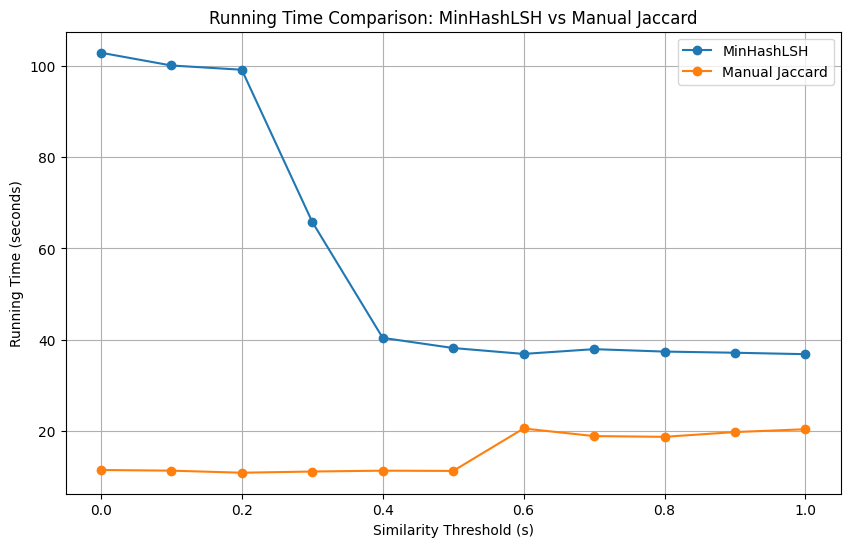

In [15]:
import matplotlib.pyplot as plt

# Lists to store running times
s_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
minhash_times = []
manual_times = []
minhash_pair_counts = []
manual_pair_counts = []
# Run both approaches for each s value
for s in s_values:
    print(f"Running for s = {s}")
    minhash_time = run_minhash_lsh(s)
    manual_time = run_optimized_manual_jaccard(s)
    minhash_times.append(minhash_time)
    manual_times.append(manual_time)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(s_values, minhash_times, label="MinHashLSH", marker='o')
plt.plot(s_values, manual_times, label="Manual Jaccard", marker='o')
plt.xlabel("Similarity Threshold (s)")
plt.ylabel("Running Time (seconds)")
plt.title("Running Time Comparison: MinHashLSH vs Manual Jaccard")
plt.legend()
plt.grid(True)
plt.show()